In [0]:
## Step 1: Importing Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Imputer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [0]:
## Step 2: Initializing Spark Session
spark = SparkSession.builder.appName("DimensionalityReduction").getOrCreate()

In [0]:
## Step 3: Loading the Dataset
file_path = "/FileStore/tables/Netflix_TV_Shows_and_Movies.csv" 
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show()

+-----+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+----------+
|index|      id|               title| type|         description|        release_year|   age_certification|             runtime|             imdb_id|       imdb_score|imdb_votes|
+-----+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+----------+
|    0| tm84618|         Taxi Driver|MOVIE|A mentally unstab...|                1976|                   R|                 113|           tt0075314|              8.3|  795222.0|
|    1|tm127384|Monty Python and ...|MOVIE|"King Arthur, acc...|                1975|                  PG|                  91|           tt0071853|8.199999999999998|  530877.0|
|    2| tm70993|       Life of Brian|MOVIE|Brian Cohen is an...|                1979|                   R|    

In [0]:
## Step 4: Inspecting the Data

# Print the schema of the dataframe
df.printSchema()

# Show a sample of the data
df.show(5)

root
 |-- index: string (nullable = true)
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- age_certification: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- imdb_score: string (nullable = true)
 |-- imdb_votes: string (nullable = true)

+-----+--------+--------------------+-----+--------------------+------------+-----------------+-------+---------+-----------------+----------+
|index|      id|               title| type|         description|release_year|age_certification|runtime|  imdb_id|       imdb_score|imdb_votes|
+-----+--------+--------------------+-----+--------------------+------------+-----------------+-------+---------+-----------------+----------+
|    0| tm84618|         Taxi Driver|MOVIE|A mentally unstab...|        1976|                R|    113|tt0075314|          

In [0]:
# Casting columns to appropriate types
df = df.withColumn("release_year", col("release_year").cast("integer"))
df = df.withColumn("runtime", col("runtime").cast("integer"))
df = df.withColumn("imdb_score", col("imdb_score").cast("float"))
df = df.withColumn("imdb_votes", col("imdb_votes").cast("float"))
# Selecting numerical columns
numerical_cols = ['release_year', 'runtime', 'imdb_score', 'imdb_votes']

# Impute missing values
imputer = Imputer(inputCols=numerical_cols, outputCols=numerical_cols).setStrategy("mean")



In [0]:
# Assemble the vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=[imputer, assembler, scaler])
model = preprocessing_pipeline.fit(df)
scaled_data = model.transform(df)


In [0]:
from pyspark.ml.feature import PCA

# Applying PCA
pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
result = pca_model.transform(scaled_data).select("pca_features")

# Collecting data for visualization (in local environment)
pca_output = result.collect()


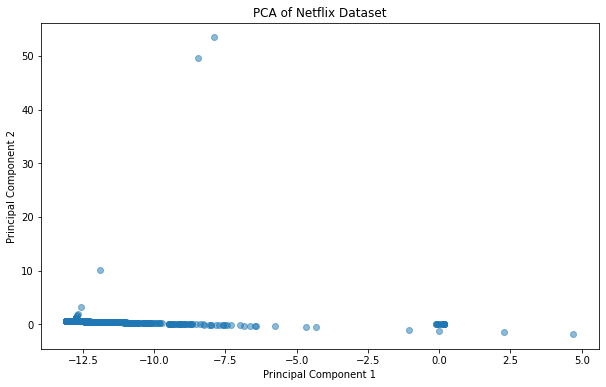

In [0]:
import matplotlib.pyplot as plt


# Extracting PCA features
pca_features = [row['pca_features'] for row in pca_output]
x = [feat[0] for feat in pca_features]  # First principal component
y = [feat[1] for feat in pca_features]  # Second principal component

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('PCA of Netflix Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
